In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-06 by mza
name = "mza_try5"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 2 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
input_quantization = 9
inner_quantization = 9
output_quantization = 9
integer_part = 1
default_quantization = 9
default_integer_part = 3
csim = False
cosim = False

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


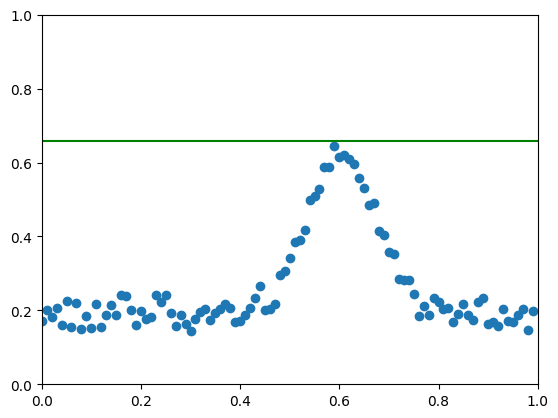

In [4]:
evt = 8
if 1:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + scaled_truths[evt][2], scaled_truths[evt][3] + scaled_truths[evt][2]], color="green")
    plt.show()

In [5]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [6]:
#, symmetric=1, keep_negative=1
input_quantizer = quantized_bits(bits=input_quantization, integer=integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
Q = "RND_CONV"
O = "SAT"
N = "0"
default_quantization_string = 'ap_fixed<' + str(default_quantization) + ',' + str(default_integer_part) + ',' + Q + ',' + O + ',' + N + '>'
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + ',' + Q + ',' + O + ',' + N + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(bits=inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(bits=input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [7]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [8]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [9]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 594us/step


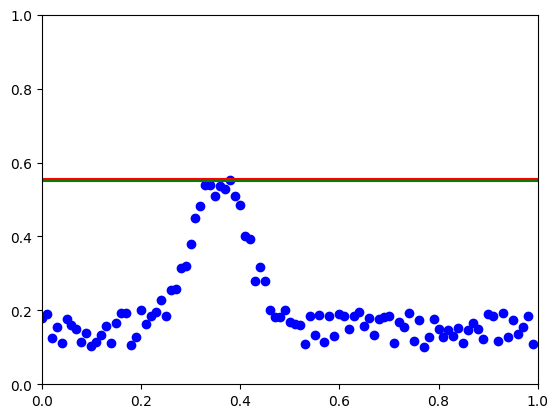

In [10]:
evt = 6
if 1:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + scaled_truths[evt][2], scaled_truths[evt][3] + scaled_truths[evt][2]], color="green")
    plt.plot([0.0, 1.0], [scaled_truths[evt][3] + train_prediction[evt][0], scaled_truths[evt][3] + train_prediction[evt][0]], color="red")
    plt.show()

In [11]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [26]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
config['IOType'] = 'io_parallel'
config['Model']['Precision']['default'] = default_quantization_string
config['Model']['Strategy'] = 'Resource'
config['Model']['ReuseFactor'] = 64 # Valid ReuseFactor(s): 1,2,4,8,16,32,64
config['LayerName']['input_qdense']['ReuseFactor'] = 10000 # Valid ReuseFactor(s): 1,2,4,5,10,20,25,50,100,200,400,500,1000,2000,2500,5000,10000
config['LayerName']['relu0qdense']['ReuseFactor'] = 6400 # Valid ReuseFactor(s): 1,2,4,5,10,20,25,50,100,200,400,800,1600,3200,6400
config['Model']['TraceOutput'] = True
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         ap_fixed<9,3,RND_CONV,SAT,0>
  ReuseFactor:       64
  Strategy:          Resource
  BramFactor:        1000000000
  TraceOutput:       True
LayerName
  input_qdense_input
    Trace:           True


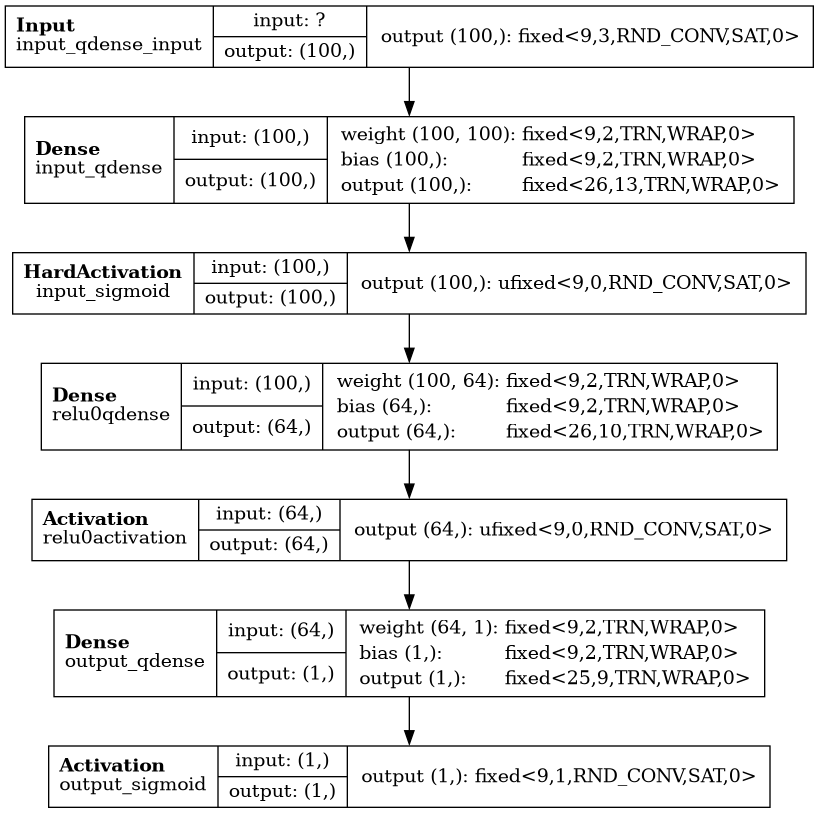

In [27]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
Image(name + '/hls_model.png')

In [28]:
hls_model.compile()

Writing HLS project
Done


/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [29]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

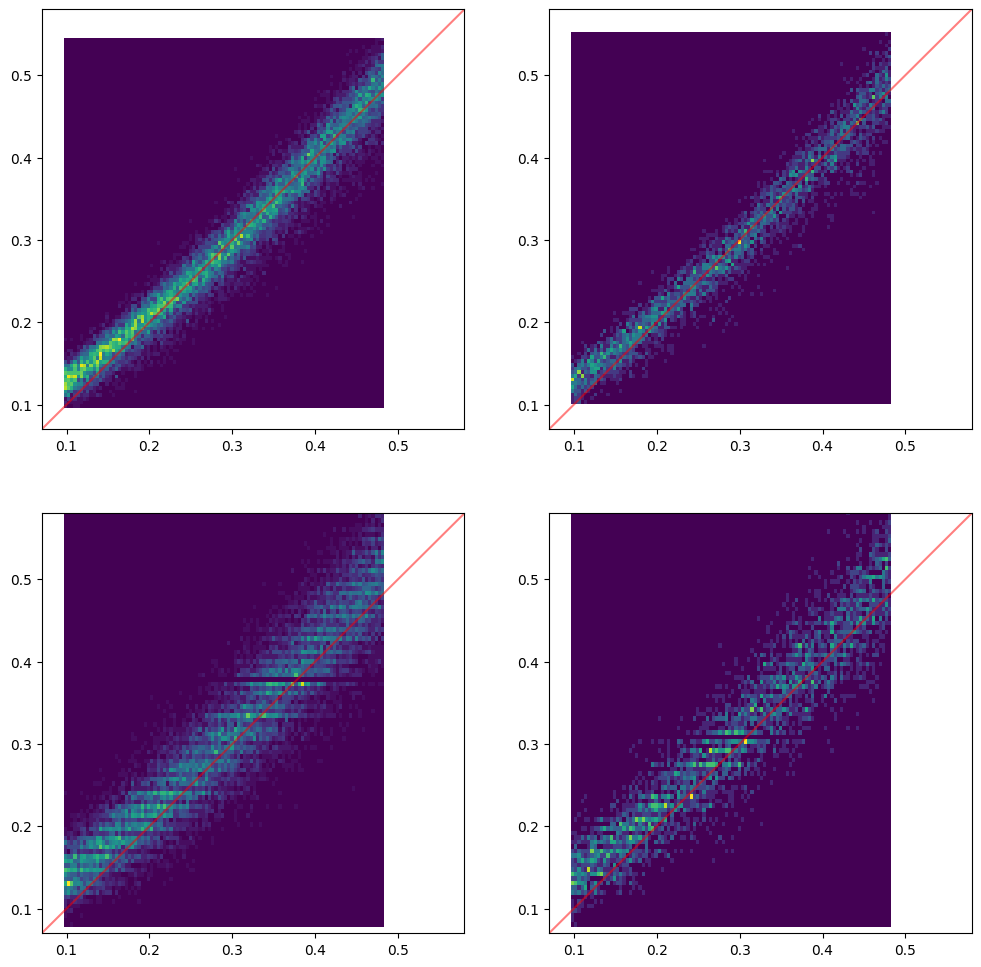

In [30]:
nbins = 100
a = 0.07; b = 0.58
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [31]:
if synth_hls:
    hls_model.build(synth=True, csim=csim, cosim=cosim)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Thu May 08 12:59:06 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 200-777] Using interface defaults for 'Vivado' flow target.
INFO: [HLS 200-1995] There were 6,299 instructions in the design after the 'Compile/Link' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 24,544 instructions in the design after the 'Unroll/Inline' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 12,585 instructions in the design after the 'Performance/Pipeline' phase of compilation. See the Design Size Report for more details: /root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 11,588 instructions in the d

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 0.43 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.43 seconds; current allocated memory: 1.112 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 0.41 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.42 seconds; current allocated memory: 1.119 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::dense_resource_rf_gt_nin_rem0<ap_fixed<9, 3, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 13, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_resource.h:164) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' into 'nnet::dense_res

INFO: [HLS 200-111] Finished Scheduling: CPU user time: 850.4 seconds. CPU system time: 0.21 seconds. Elapsed time: 850.83 seconds; current allocated memory: 1.735 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 5.9 seconds. CPU system time: 0.02 seconds. Elapsed time: 5.94 seconds; current allocated memory: 1.735 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'hard_sigmoid_ap_fixed_ap_ufixed_9_0_4_0_0_hard_sigmoid_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'hard_sigmoid<ap_fixed,ap_ufixed<9,0,4,0

Resolution: For help on HLS 200-871 see www.xilinx.com/cgi-bin/docs/rdoc?v=2023.1;t=hls+guidance;d=200-871.html
	'call' operation ('call_ret1', firmware/nnet_utils/nnet_dense.h:76->firmware/nnet_utils/nnet_dense.h:45->firmware/myproject.cpp:38) to 'dense_resource_rf_gt_nin_rem0<ap_fixed,ap_fixed<26,13,5,3,0>,config2>' [18]  (16.199 ns)

Resolution: For help on HLS 200-1016 see www.xilinx.com/cgi-bin/docs/rdoc?v=2023.1;t=hls+guidance;d=200-1016.html
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.19 seconds. CPU system time: 0 seconds. Elapsed time: 0.19 seconds; current allocated memory: 1.735 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.2 seconds. CPU system

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s_sigmoid_table_ROM_AUTO_1R' to 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s_sigmoid_tabg8j' due to the length limit 80
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s' pipeline 'sigmoid<ap_fixed<25, 9, 5, 3, 0>, ap_fixed<9, 1, 4, 0, 0>, sigmoid_config10>' pipeline type 'function pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_4_0_0_sigmoid_config10_s'.
INFO: [RTMG 210-279] Implementing memory 'myproject_sigmoid_ap_fixed_25_9_5_3_0_ap_fixed_9_1_

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_91_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_92_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_93_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_94_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_95_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_96_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_97_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_98_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_99_U(myproject_fifo_w16_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_U(my

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_70_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_71_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_72_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_73_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_74_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_75_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_76_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_77_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_78_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_79_U(myprojec

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_40_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_41_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_42_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_43_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_44_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_45_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_46_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_47_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_48_U(myproject_fifo_w9_d2_S)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_49_U(myprojec

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16ns_13s_29_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16ns_13s_29_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_dense_resource_rf_leq_nin_ap_ufixed_ap_fixed_26_10_5_3_0_config5_s_w5_91_ROM_cud.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_dense_resource_rf_leq_nin_ap_ufixed_ap_fixed_26_10_5_3_0_config5_s_w5_91_ROM_cud
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_9ns_6ns_14_3_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_9ns_6ns_14_3_1
INFO: [VRFC 10-2263] A

Starting static elaboration
Pass Through NonSizing Optimizer


Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling package xil_defaultlib.$unit_dataflow_monitor_sv
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_lshr_900ns_10ns_900_7_...
Compiling module xil_defaultlib.myproject_mul_9s_7s_16_3_1(NUM_S...
Compiling module xil_defaultlib.myproject_mux_100_7_9_2_1(ID=1,N...
Compiling module xil_defaultlib.myproject_flow_control_loop_pipe
Compiling module xil_defaultlib.myproject_frp_pipeline_valid(Pip...
Compiling module xil_defaultlib.myproject_frp_fifoout(BlockingTy...
Compiling module xil_defaultlib.myproject_dense_resource_rf_gt_n...
Compiling module xil_defaultlib.myproject_frp_pipeline_valid(Pip...
Compiling module xil_defaultlib.myproject_frp_fifoout(BlockingTy...
Compiling module xil_defaultlib.myproject_hard_sig

// RTL Simulation : 1 / 4000 [39.38%] @ "82603000"
// RTL Simulation : 2 / 4000 [39.38%] @ "132603000"
// RTL Simulation : 3 / 4000 [39.38%] @ "182603000"
// RTL Simulation : 4 / 4000 [39.38%] @ "232603000"
// RTL Simulation : 5 / 4000 [39.38%] @ "282603000"
// RTL Simulation : 6 / 4000 [39.38%] @ "332603000"
// RTL Simulation : 7 / 4000 [39.38%] @ "382603000"
// RTL Simulation : 8 / 4000 [39.38%] @ "432603000"
// RTL Simulation : 9 / 4000 [39.38%] @ "482603000"
// RTL Simulation : 10 / 4000 [39.38%] @ "532603000"
// RTL Simulation : 11 / 4000 [39.38%] @ "582603000"
// RTL Simulation : 12 / 4000 [39.38%] @ "632603000"
// RTL Simulation : 13 / 4000 [39.38%] @ "682603000"
// RTL Simulation : 14 / 4000 [39.38%] @ "732603000"
// RTL Simulation : 15 / 4000 [39.38%] @ "782603000"
// RTL Simulation : 16 / 4000 [39.38%] @ "832603000"
// RTL Simulation : 17 / 4000 [39.38%] @ "882603000"
// RTL Simulation : 18 / 4000 [39.38%] @ "932603000"
// RTL Simulation : 19 / 4000 [39.38%] @ "982603000"
// 

// RTL Simulation : 153 / 4000 [39.38%] @ "7682603000"
// RTL Simulation : 154 / 4000 [39.38%] @ "7732603000"
// RTL Simulation : 155 / 4000 [39.38%] @ "7782603000"
// RTL Simulation : 156 / 4000 [39.38%] @ "7832603000"
// RTL Simulation : 157 / 4000 [39.38%] @ "7882603000"
// RTL Simulation : 158 / 4000 [39.38%] @ "7932603000"
// RTL Simulation : 159 / 4000 [39.38%] @ "7982603000"
// RTL Simulation : 160 / 4000 [39.38%] @ "8032603000"
// RTL Simulation : 161 / 4000 [39.38%] @ "8082603000"
// RTL Simulation : 162 / 4000 [39.38%] @ "8132603000"
// RTL Simulation : 163 / 4000 [39.38%] @ "8182603000"
// RTL Simulation : 164 / 4000 [39.38%] @ "8232603000"
// RTL Simulation : 165 / 4000 [39.38%] @ "8282603000"
// RTL Simulation : 166 / 4000 [39.38%] @ "8332603000"
// RTL Simulation : 167 / 4000 [39.38%] @ "8382603000"
// RTL Simulation : 168 / 4000 [39.38%] @ "8432603000"
// RTL Simulation : 169 / 4000 [39.38%] @ "8482603000"
// RTL Simulation : 170 / 4000 [39.38%] @ "8532603000"
// RTL Sim

// RTL Simulation : 301 / 4000 [39.38%] @ "15082603000"
// RTL Simulation : 302 / 4000 [39.38%] @ "15132603000"
// RTL Simulation : 303 / 4000 [39.38%] @ "15182603000"
// RTL Simulation : 304 / 4000 [39.38%] @ "15232603000"
// RTL Simulation : 305 / 4000 [39.38%] @ "15282603000"
// RTL Simulation : 306 / 4000 [39.38%] @ "15332603000"
// RTL Simulation : 307 / 4000 [39.38%] @ "15382603000"
// RTL Simulation : 308 / 4000 [39.38%] @ "15432603000"
// RTL Simulation : 309 / 4000 [39.38%] @ "15482603000"
// RTL Simulation : 310 / 4000 [39.38%] @ "15532603000"
// RTL Simulation : 311 / 4000 [39.38%] @ "15582603000"
// RTL Simulation : 312 / 4000 [39.38%] @ "15632603000"
// RTL Simulation : 313 / 4000 [39.38%] @ "15682603000"
// RTL Simulation : 314 / 4000 [39.38%] @ "15732603000"
// RTL Simulation : 315 / 4000 [39.38%] @ "15782603000"
// RTL Simulation : 316 / 4000 [39.38%] @ "15832603000"
// RTL Simulation : 317 / 4000 [39.38%] @ "15882603000"
// RTL Simulation : 318 / 4000 [39.38%] @ "15932

// RTL Simulation : 448 / 4000 [39.38%] @ "22432603000"
// RTL Simulation : 449 / 4000 [39.38%] @ "22482603000"
// RTL Simulation : 450 / 4000 [39.38%] @ "22532603000"
// RTL Simulation : 451 / 4000 [39.38%] @ "22582603000"
// RTL Simulation : 452 / 4000 [39.38%] @ "22632603000"
// RTL Simulation : 453 / 4000 [39.38%] @ "22682603000"
// RTL Simulation : 454 / 4000 [39.38%] @ "22732603000"
// RTL Simulation : 455 / 4000 [39.38%] @ "22782603000"
// RTL Simulation : 456 / 4000 [39.38%] @ "22832603000"
// RTL Simulation : 457 / 4000 [39.38%] @ "22882603000"
// RTL Simulation : 458 / 4000 [39.38%] @ "22932603000"
// RTL Simulation : 459 / 4000 [39.38%] @ "22982603000"
// RTL Simulation : 460 / 4000 [39.38%] @ "23032603000"
// RTL Simulation : 461 / 4000 [39.38%] @ "23082603000"
// RTL Simulation : 462 / 4000 [39.38%] @ "23132603000"
// RTL Simulation : 463 / 4000 [39.38%] @ "23182603000"
// RTL Simulation : 464 / 4000 [39.38%] @ "23232603000"
// RTL Simulation : 465 / 4000 [39.38%] @ "23282

// RTL Simulation : 595 / 4000 [39.38%] @ "29782603000"
// RTL Simulation : 596 / 4000 [39.38%] @ "29832603000"
// RTL Simulation : 597 / 4000 [39.38%] @ "29882603000"
// RTL Simulation : 598 / 4000 [39.38%] @ "29932603000"
// RTL Simulation : 599 / 4000 [39.38%] @ "29982603000"
// RTL Simulation : 600 / 4000 [39.38%] @ "30032603000"
// RTL Simulation : 601 / 4000 [39.38%] @ "30082603000"
// RTL Simulation : 602 / 4000 [39.38%] @ "30132603000"
// RTL Simulation : 603 / 4000 [39.38%] @ "30182603000"
// RTL Simulation : 604 / 4000 [39.38%] @ "30232603000"
// RTL Simulation : 605 / 4000 [39.38%] @ "30282603000"
// RTL Simulation : 606 / 4000 [39.38%] @ "30332603000"
// RTL Simulation : 607 / 4000 [39.38%] @ "30382603000"
// RTL Simulation : 608 / 4000 [39.38%] @ "30432603000"
// RTL Simulation : 609 / 4000 [39.38%] @ "30482603000"
// RTL Simulation : 610 / 4000 [39.38%] @ "30532603000"
// RTL Simulation : 611 / 4000 [39.38%] @ "30582603000"
// RTL Simulation : 612 / 4000 [39.38%] @ "30632

// RTL Simulation : 742 / 4000 [39.38%] @ "37132603000"
// RTL Simulation : 743 / 4000 [39.38%] @ "37182603000"
// RTL Simulation : 744 / 4000 [39.38%] @ "37232603000"
// RTL Simulation : 745 / 4000 [39.38%] @ "37282603000"
// RTL Simulation : 746 / 4000 [39.38%] @ "37332603000"
// RTL Simulation : 747 / 4000 [39.38%] @ "37382603000"
// RTL Simulation : 748 / 4000 [39.38%] @ "37432603000"
// RTL Simulation : 749 / 4000 [39.38%] @ "37482603000"
// RTL Simulation : 750 / 4000 [39.38%] @ "37532603000"
// RTL Simulation : 751 / 4000 [39.38%] @ "37582603000"
// RTL Simulation : 752 / 4000 [39.38%] @ "37632603000"
// RTL Simulation : 753 / 4000 [39.38%] @ "37682603000"
// RTL Simulation : 754 / 4000 [39.38%] @ "37732603000"
// RTL Simulation : 755 / 4000 [39.38%] @ "37782603000"
// RTL Simulation : 756 / 4000 [39.38%] @ "37832603000"
// RTL Simulation : 757 / 4000 [39.38%] @ "37882603000"
// RTL Simulation : 758 / 4000 [39.38%] @ "37932603000"
// RTL Simulation : 759 / 4000 [39.38%] @ "37982

// RTL Simulation : 889 / 4000 [39.38%] @ "44482603000"
// RTL Simulation : 890 / 4000 [39.38%] @ "44532603000"
// RTL Simulation : 891 / 4000 [39.38%] @ "44582603000"
// RTL Simulation : 892 / 4000 [39.38%] @ "44632603000"
// RTL Simulation : 893 / 4000 [39.38%] @ "44682603000"
// RTL Simulation : 894 / 4000 [39.38%] @ "44732603000"
// RTL Simulation : 895 / 4000 [39.38%] @ "44782603000"
// RTL Simulation : 896 / 4000 [39.38%] @ "44832603000"
// RTL Simulation : 897 / 4000 [39.38%] @ "44882603000"
// RTL Simulation : 898 / 4000 [39.38%] @ "44932603000"
// RTL Simulation : 899 / 4000 [39.38%] @ "44982603000"
// RTL Simulation : 900 / 4000 [39.38%] @ "45032603000"
// RTL Simulation : 901 / 4000 [39.38%] @ "45082603000"
// RTL Simulation : 902 / 4000 [39.38%] @ "45132603000"
// RTL Simulation : 903 / 4000 [39.38%] @ "45182603000"
// RTL Simulation : 904 / 4000 [39.38%] @ "45232603000"
// RTL Simulation : 905 / 4000 [39.38%] @ "45282603000"
// RTL Simulation : 906 / 4000 [39.38%] @ "45332

// RTL Simulation : 1035 / 4000 [39.38%] @ "51782603000"
// RTL Simulation : 1036 / 4000 [39.38%] @ "51832603000"
// RTL Simulation : 1037 / 4000 [39.38%] @ "51882603000"
// RTL Simulation : 1038 / 4000 [39.38%] @ "51932603000"
// RTL Simulation : 1039 / 4000 [39.38%] @ "51982603000"
// RTL Simulation : 1040 / 4000 [39.38%] @ "52032603000"
// RTL Simulation : 1041 / 4000 [39.38%] @ "52082603000"
// RTL Simulation : 1042 / 4000 [39.38%] @ "52132603000"
// RTL Simulation : 1043 / 4000 [39.38%] @ "52182603000"
// RTL Simulation : 1044 / 4000 [39.38%] @ "52232603000"
// RTL Simulation : 1045 / 4000 [39.38%] @ "52282603000"
// RTL Simulation : 1046 / 4000 [39.38%] @ "52332603000"
// RTL Simulation : 1047 / 4000 [39.38%] @ "52382603000"
// RTL Simulation : 1048 / 4000 [39.38%] @ "52432603000"
// RTL Simulation : 1049 / 4000 [39.38%] @ "52482603000"
// RTL Simulation : 1050 / 4000 [39.38%] @ "52532603000"
// RTL Simulation : 1051 / 4000 [39.38%] @ "52582603000"
// RTL Simulation : 1052 / 4000

// RTL Simulation : 1179 / 4000 [39.38%] @ "58982603000"
// RTL Simulation : 1180 / 4000 [39.38%] @ "59032603000"
// RTL Simulation : 1181 / 4000 [39.38%] @ "59082603000"
// RTL Simulation : 1182 / 4000 [39.38%] @ "59132603000"
// RTL Simulation : 1183 / 4000 [39.38%] @ "59182603000"
// RTL Simulation : 1184 / 4000 [39.38%] @ "59232603000"
// RTL Simulation : 1185 / 4000 [39.38%] @ "59282603000"
// RTL Simulation : 1186 / 4000 [39.38%] @ "59332603000"
// RTL Simulation : 1187 / 4000 [39.38%] @ "59382603000"
// RTL Simulation : 1188 / 4000 [39.38%] @ "59432603000"
// RTL Simulation : 1189 / 4000 [39.38%] @ "59482603000"
// RTL Simulation : 1190 / 4000 [39.38%] @ "59532603000"
// RTL Simulation : 1191 / 4000 [39.38%] @ "59582603000"
// RTL Simulation : 1192 / 4000 [39.38%] @ "59632603000"
// RTL Simulation : 1193 / 4000 [39.38%] @ "59682603000"
// RTL Simulation : 1194 / 4000 [39.38%] @ "59732603000"
// RTL Simulation : 1195 / 4000 [39.38%] @ "59782603000"
// RTL Simulation : 1196 / 4000

// RTL Simulation : 1323 / 4000 [39.38%] @ "66182603000"
// RTL Simulation : 1324 / 4000 [39.38%] @ "66232603000"
// RTL Simulation : 1325 / 4000 [39.38%] @ "66282603000"
// RTL Simulation : 1326 / 4000 [39.38%] @ "66332603000"
// RTL Simulation : 1327 / 4000 [39.38%] @ "66382603000"
// RTL Simulation : 1328 / 4000 [39.38%] @ "66432603000"
// RTL Simulation : 1329 / 4000 [39.38%] @ "66482603000"
// RTL Simulation : 1330 / 4000 [39.38%] @ "66532603000"
// RTL Simulation : 1331 / 4000 [39.38%] @ "66582603000"
// RTL Simulation : 1332 / 4000 [39.38%] @ "66632603000"
// RTL Simulation : 1333 / 4000 [39.38%] @ "66682603000"
// RTL Simulation : 1334 / 4000 [39.38%] @ "66732603000"
// RTL Simulation : 1335 / 4000 [39.38%] @ "66782603000"
// RTL Simulation : 1336 / 4000 [39.38%] @ "66832603000"
// RTL Simulation : 1337 / 4000 [39.38%] @ "66882603000"
// RTL Simulation : 1338 / 4000 [39.38%] @ "66932603000"
// RTL Simulation : 1339 / 4000 [39.38%] @ "66982603000"
// RTL Simulation : 1340 / 4000

// RTL Simulation : 1467 / 4000 [39.38%] @ "73382603000"
// RTL Simulation : 1468 / 4000 [39.38%] @ "73432603000"
// RTL Simulation : 1469 / 4000 [39.38%] @ "73482603000"
// RTL Simulation : 1470 / 4000 [39.38%] @ "73532603000"
// RTL Simulation : 1471 / 4000 [39.38%] @ "73582603000"
// RTL Simulation : 1472 / 4000 [39.38%] @ "73632603000"
// RTL Simulation : 1473 / 4000 [39.38%] @ "73682603000"
// RTL Simulation : 1474 / 4000 [39.38%] @ "73732603000"
// RTL Simulation : 1475 / 4000 [39.38%] @ "73782603000"
// RTL Simulation : 1476 / 4000 [39.38%] @ "73832603000"
// RTL Simulation : 1477 / 4000 [39.38%] @ "73882603000"
// RTL Simulation : 1478 / 4000 [39.38%] @ "73932603000"
// RTL Simulation : 1479 / 4000 [39.38%] @ "73982603000"
// RTL Simulation : 1480 / 4000 [39.38%] @ "74032603000"
// RTL Simulation : 1481 / 4000 [39.38%] @ "74082603000"
// RTL Simulation : 1482 / 4000 [39.38%] @ "74132603000"
// RTL Simulation : 1483 / 4000 [39.38%] @ "74182603000"
// RTL Simulation : 1484 / 4000

// RTL Simulation : 1611 / 4000 [39.38%] @ "80582603000"
// RTL Simulation : 1612 / 4000 [39.38%] @ "80632603000"
// RTL Simulation : 1613 / 4000 [39.38%] @ "80682603000"
// RTL Simulation : 1614 / 4000 [39.38%] @ "80732603000"
// RTL Simulation : 1615 / 4000 [39.38%] @ "80782603000"
// RTL Simulation : 1616 / 4000 [39.38%] @ "80832603000"
// RTL Simulation : 1617 / 4000 [39.38%] @ "80882603000"
// RTL Simulation : 1618 / 4000 [39.38%] @ "80932603000"
// RTL Simulation : 1619 / 4000 [39.38%] @ "80982603000"
// RTL Simulation : 1620 / 4000 [39.38%] @ "81032603000"
// RTL Simulation : 1621 / 4000 [39.38%] @ "81082603000"
// RTL Simulation : 1622 / 4000 [39.38%] @ "81132603000"
// RTL Simulation : 1623 / 4000 [39.38%] @ "81182603000"
// RTL Simulation : 1624 / 4000 [39.38%] @ "81232603000"
// RTL Simulation : 1625 / 4000 [39.38%] @ "81282603000"
// RTL Simulation : 1626 / 4000 [39.38%] @ "81332603000"
// RTL Simulation : 1627 / 4000 [39.38%] @ "81382603000"
// RTL Simulation : 1628 / 4000

// RTL Simulation : 1755 / 4000 [39.38%] @ "87782603000"
// RTL Simulation : 1756 / 4000 [39.38%] @ "87832603000"
// RTL Simulation : 1757 / 4000 [39.38%] @ "87882603000"
// RTL Simulation : 1758 / 4000 [39.38%] @ "87932603000"
// RTL Simulation : 1759 / 4000 [39.38%] @ "87982603000"
// RTL Simulation : 1760 / 4000 [39.38%] @ "88032603000"
// RTL Simulation : 1761 / 4000 [39.38%] @ "88082603000"
// RTL Simulation : 1762 / 4000 [39.38%] @ "88132603000"
// RTL Simulation : 1763 / 4000 [39.38%] @ "88182603000"
// RTL Simulation : 1764 / 4000 [39.38%] @ "88232603000"
// RTL Simulation : 1765 / 4000 [39.38%] @ "88282603000"
// RTL Simulation : 1766 / 4000 [39.38%] @ "88332603000"
// RTL Simulation : 1767 / 4000 [39.38%] @ "88382603000"
// RTL Simulation : 1768 / 4000 [39.38%] @ "88432603000"
// RTL Simulation : 1769 / 4000 [39.38%] @ "88482603000"
// RTL Simulation : 1770 / 4000 [39.38%] @ "88532603000"
// RTL Simulation : 1771 / 4000 [39.38%] @ "88582603000"
// RTL Simulation : 1772 / 4000

// RTL Simulation : 1899 / 4000 [39.38%] @ "94982603000"
// RTL Simulation : 1900 / 4000 [39.38%] @ "95032603000"
// RTL Simulation : 1901 / 4000 [39.38%] @ "95082603000"
// RTL Simulation : 1902 / 4000 [39.38%] @ "95132603000"
// RTL Simulation : 1903 / 4000 [39.38%] @ "95182603000"
// RTL Simulation : 1904 / 4000 [39.38%] @ "95232603000"
// RTL Simulation : 1905 / 4000 [39.38%] @ "95282603000"
// RTL Simulation : 1906 / 4000 [39.38%] @ "95332603000"
// RTL Simulation : 1907 / 4000 [39.38%] @ "95382603000"
// RTL Simulation : 1908 / 4000 [39.38%] @ "95432603000"
// RTL Simulation : 1909 / 4000 [39.38%] @ "95482603000"
// RTL Simulation : 1910 / 4000 [39.38%] @ "95532603000"
// RTL Simulation : 1911 / 4000 [39.38%] @ "95582603000"
// RTL Simulation : 1912 / 4000 [39.38%] @ "95632603000"
// RTL Simulation : 1913 / 4000 [39.38%] @ "95682603000"
// RTL Simulation : 1914 / 4000 [39.38%] @ "95732603000"
// RTL Simulation : 1915 / 4000 [39.38%] @ "95782603000"
// RTL Simulation : 1916 / 4000

// RTL Simulation : 2042 / 4000 [39.38%] @ "102132603000"
// RTL Simulation : 2043 / 4000 [39.38%] @ "102182603000"
// RTL Simulation : 2044 / 4000 [39.38%] @ "102232603000"
// RTL Simulation : 2045 / 4000 [39.38%] @ "102282603000"
// RTL Simulation : 2046 / 4000 [39.38%] @ "102332603000"
// RTL Simulation : 2047 / 4000 [39.38%] @ "102382603000"
// RTL Simulation : 2048 / 4000 [39.38%] @ "102432603000"
// RTL Simulation : 2049 / 4000 [39.38%] @ "102482603000"
// RTL Simulation : 2050 / 4000 [39.38%] @ "102532603000"
// RTL Simulation : 2051 / 4000 [39.38%] @ "102582603000"
// RTL Simulation : 2052 / 4000 [39.38%] @ "102632603000"
// RTL Simulation : 2053 / 4000 [39.38%] @ "102682603000"
// RTL Simulation : 2054 / 4000 [39.38%] @ "102732603000"
// RTL Simulation : 2055 / 4000 [39.38%] @ "102782603000"
// RTL Simulation : 2056 / 4000 [39.38%] @ "102832603000"
// RTL Simulation : 2057 / 4000 [39.38%] @ "102882603000"
// RTL Simulation : 2058 / 4000 [39.38%] @ "102932603000"
// RTL Simulat

// RTL Simulation : 2184 / 4000 [39.38%] @ "109232603000"
// RTL Simulation : 2185 / 4000 [39.38%] @ "109282603000"
// RTL Simulation : 2186 / 4000 [39.38%] @ "109332603000"
// RTL Simulation : 2187 / 4000 [39.38%] @ "109382603000"
// RTL Simulation : 2188 / 4000 [39.38%] @ "109432603000"
// RTL Simulation : 2189 / 4000 [39.38%] @ "109482603000"
// RTL Simulation : 2190 / 4000 [39.38%] @ "109532603000"
// RTL Simulation : 2191 / 4000 [39.38%] @ "109582603000"
// RTL Simulation : 2192 / 4000 [39.38%] @ "109632603000"
// RTL Simulation : 2193 / 4000 [39.38%] @ "109682603000"
// RTL Simulation : 2194 / 4000 [39.38%] @ "109732603000"
// RTL Simulation : 2195 / 4000 [39.38%] @ "109782603000"
// RTL Simulation : 2196 / 4000 [39.38%] @ "109832603000"
// RTL Simulation : 2197 / 4000 [39.38%] @ "109882603000"
// RTL Simulation : 2198 / 4000 [39.38%] @ "109932603000"
// RTL Simulation : 2199 / 4000 [39.38%] @ "109982603000"
// RTL Simulation : 2200 / 4000 [39.38%] @ "110032603000"
// RTL Simulat

// RTL Simulation : 2326 / 4000 [39.38%] @ "116332603000"
// RTL Simulation : 2327 / 4000 [39.38%] @ "116382603000"
// RTL Simulation : 2328 / 4000 [39.38%] @ "116432603000"
// RTL Simulation : 2329 / 4000 [39.38%] @ "116482603000"
// RTL Simulation : 2330 / 4000 [39.38%] @ "116532603000"
// RTL Simulation : 2331 / 4000 [39.38%] @ "116582603000"
// RTL Simulation : 2332 / 4000 [39.38%] @ "116632603000"
// RTL Simulation : 2333 / 4000 [39.38%] @ "116682603000"
// RTL Simulation : 2334 / 4000 [39.38%] @ "116732603000"
// RTL Simulation : 2335 / 4000 [39.38%] @ "116782603000"
// RTL Simulation : 2336 / 4000 [39.38%] @ "116832603000"
// RTL Simulation : 2337 / 4000 [39.38%] @ "116882603000"
// RTL Simulation : 2338 / 4000 [39.38%] @ "116932603000"
// RTL Simulation : 2339 / 4000 [39.38%] @ "116982603000"
// RTL Simulation : 2340 / 4000 [39.38%] @ "117032603000"
// RTL Simulation : 2341 / 4000 [39.38%] @ "117082603000"
// RTL Simulation : 2342 / 4000 [39.38%] @ "117132603000"
// RTL Simulat

// RTL Simulation : 2468 / 4000 [39.38%] @ "123432603000"
// RTL Simulation : 2469 / 4000 [39.38%] @ "123482603000"
// RTL Simulation : 2470 / 4000 [39.38%] @ "123532603000"
// RTL Simulation : 2471 / 4000 [39.38%] @ "123582603000"
// RTL Simulation : 2472 / 4000 [39.38%] @ "123632603000"
// RTL Simulation : 2473 / 4000 [39.38%] @ "123682603000"
// RTL Simulation : 2474 / 4000 [39.38%] @ "123732603000"
// RTL Simulation : 2475 / 4000 [39.38%] @ "123782603000"
// RTL Simulation : 2476 / 4000 [39.38%] @ "123832603000"
// RTL Simulation : 2477 / 4000 [39.38%] @ "123882603000"
// RTL Simulation : 2478 / 4000 [39.38%] @ "123932603000"
// RTL Simulation : 2479 / 4000 [39.38%] @ "123982603000"
// RTL Simulation : 2480 / 4000 [39.38%] @ "124032603000"
// RTL Simulation : 2481 / 4000 [39.38%] @ "124082603000"
// RTL Simulation : 2482 / 4000 [39.38%] @ "124132603000"
// RTL Simulation : 2483 / 4000 [39.38%] @ "124182603000"
// RTL Simulation : 2484 / 4000 [39.38%] @ "124232603000"
// RTL Simulat

// RTL Simulation : 2610 / 4000 [39.38%] @ "130532603000"
// RTL Simulation : 2611 / 4000 [39.38%] @ "130582603000"
// RTL Simulation : 2612 / 4000 [39.38%] @ "130632603000"
// RTL Simulation : 2613 / 4000 [39.38%] @ "130682603000"
// RTL Simulation : 2614 / 4000 [39.38%] @ "130732603000"
// RTL Simulation : 2615 / 4000 [39.38%] @ "130782603000"
// RTL Simulation : 2616 / 4000 [39.38%] @ "130832603000"
// RTL Simulation : 2617 / 4000 [39.38%] @ "130882603000"
// RTL Simulation : 2618 / 4000 [39.38%] @ "130932603000"
// RTL Simulation : 2619 / 4000 [39.38%] @ "130982603000"
// RTL Simulation : 2620 / 4000 [39.38%] @ "131032603000"
// RTL Simulation : 2621 / 4000 [39.38%] @ "131082603000"
// RTL Simulation : 2622 / 4000 [39.38%] @ "131132603000"
// RTL Simulation : 2623 / 4000 [39.38%] @ "131182603000"
// RTL Simulation : 2624 / 4000 [39.38%] @ "131232603000"
// RTL Simulation : 2625 / 4000 [39.38%] @ "131282603000"
// RTL Simulation : 2626 / 4000 [39.38%] @ "131332603000"
// RTL Simulat

// RTL Simulation : 2752 / 4000 [39.38%] @ "137632603000"
// RTL Simulation : 2753 / 4000 [39.38%] @ "137682603000"
// RTL Simulation : 2754 / 4000 [39.38%] @ "137732603000"
// RTL Simulation : 2755 / 4000 [39.38%] @ "137782603000"
// RTL Simulation : 2756 / 4000 [39.38%] @ "137832603000"
// RTL Simulation : 2757 / 4000 [39.38%] @ "137882603000"
// RTL Simulation : 2758 / 4000 [39.38%] @ "137932603000"
// RTL Simulation : 2759 / 4000 [39.38%] @ "137982603000"
// RTL Simulation : 2760 / 4000 [39.38%] @ "138032603000"
// RTL Simulation : 2761 / 4000 [39.38%] @ "138082603000"
// RTL Simulation : 2762 / 4000 [39.38%] @ "138132603000"
// RTL Simulation : 2763 / 4000 [39.38%] @ "138182603000"
// RTL Simulation : 2764 / 4000 [39.38%] @ "138232603000"
// RTL Simulation : 2765 / 4000 [39.38%] @ "138282603000"
// RTL Simulation : 2766 / 4000 [39.38%] @ "138332603000"
// RTL Simulation : 2767 / 4000 [39.38%] @ "138382603000"
// RTL Simulation : 2768 / 4000 [39.38%] @ "138432603000"
// RTL Simulat

// RTL Simulation : 2894 / 4000 [39.38%] @ "144732603000"
// RTL Simulation : 2895 / 4000 [39.38%] @ "144782603000"
// RTL Simulation : 2896 / 4000 [39.38%] @ "144832603000"
// RTL Simulation : 2897 / 4000 [39.38%] @ "144882603000"
// RTL Simulation : 2898 / 4000 [39.38%] @ "144932603000"
// RTL Simulation : 2899 / 4000 [39.38%] @ "144982603000"
// RTL Simulation : 2900 / 4000 [39.38%] @ "145032603000"
// RTL Simulation : 2901 / 4000 [39.38%] @ "145082603000"
// RTL Simulation : 2902 / 4000 [39.38%] @ "145132603000"
// RTL Simulation : 2903 / 4000 [39.38%] @ "145182603000"
// RTL Simulation : 2904 / 4000 [39.38%] @ "145232603000"
// RTL Simulation : 2905 / 4000 [39.38%] @ "145282603000"
// RTL Simulation : 2906 / 4000 [39.38%] @ "145332603000"
// RTL Simulation : 2907 / 4000 [39.38%] @ "145382603000"
// RTL Simulation : 2908 / 4000 [39.38%] @ "145432603000"
// RTL Simulation : 2909 / 4000 [39.38%] @ "145482603000"
// RTL Simulation : 2910 / 4000 [39.38%] @ "145532603000"
// RTL Simulat

// RTL Simulation : 3036 / 4000 [39.38%] @ "151832603000"
// RTL Simulation : 3037 / 4000 [39.38%] @ "151882603000"
// RTL Simulation : 3038 / 4000 [39.38%] @ "151932603000"
// RTL Simulation : 3039 / 4000 [39.38%] @ "151982603000"
// RTL Simulation : 3040 / 4000 [39.38%] @ "152032603000"
// RTL Simulation : 3041 / 4000 [39.38%] @ "152082603000"
// RTL Simulation : 3042 / 4000 [39.38%] @ "152132603000"
// RTL Simulation : 3043 / 4000 [39.38%] @ "152182603000"
// RTL Simulation : 3044 / 4000 [39.38%] @ "152232603000"
// RTL Simulation : 3045 / 4000 [39.38%] @ "152282603000"
// RTL Simulation : 3046 / 4000 [39.38%] @ "152332603000"
// RTL Simulation : 3047 / 4000 [39.38%] @ "152382603000"
// RTL Simulation : 3048 / 4000 [39.38%] @ "152432603000"
// RTL Simulation : 3049 / 4000 [39.38%] @ "152482603000"
// RTL Simulation : 3050 / 4000 [39.38%] @ "152532603000"
// RTL Simulation : 3051 / 4000 [39.38%] @ "152582603000"
// RTL Simulation : 3052 / 4000 [39.38%] @ "152632603000"
// RTL Simulat

// RTL Simulation : 3178 / 4000 [39.38%] @ "158932603000"
// RTL Simulation : 3179 / 4000 [39.38%] @ "158982603000"
// RTL Simulation : 3180 / 4000 [39.38%] @ "159032603000"
// RTL Simulation : 3181 / 4000 [39.38%] @ "159082603000"
// RTL Simulation : 3182 / 4000 [39.38%] @ "159132603000"
// RTL Simulation : 3183 / 4000 [39.38%] @ "159182603000"
// RTL Simulation : 3184 / 4000 [39.38%] @ "159232603000"
// RTL Simulation : 3185 / 4000 [39.38%] @ "159282603000"
// RTL Simulation : 3186 / 4000 [39.38%] @ "159332603000"
// RTL Simulation : 3187 / 4000 [39.38%] @ "159382603000"
// RTL Simulation : 3188 / 4000 [39.38%] @ "159432603000"
// RTL Simulation : 3189 / 4000 [39.38%] @ "159482603000"
// RTL Simulation : 3190 / 4000 [39.38%] @ "159532603000"
// RTL Simulation : 3191 / 4000 [39.38%] @ "159582603000"
// RTL Simulation : 3192 / 4000 [39.38%] @ "159632603000"
// RTL Simulation : 3193 / 4000 [39.38%] @ "159682603000"
// RTL Simulation : 3194 / 4000 [39.38%] @ "159732603000"
// RTL Simulat

// RTL Simulation : 3320 / 4000 [39.38%] @ "166032603000"
// RTL Simulation : 3321 / 4000 [39.38%] @ "166082603000"
// RTL Simulation : 3322 / 4000 [39.38%] @ "166132603000"
// RTL Simulation : 3323 / 4000 [39.38%] @ "166182603000"
// RTL Simulation : 3324 / 4000 [39.38%] @ "166232603000"
// RTL Simulation : 3325 / 4000 [39.38%] @ "166282603000"
// RTL Simulation : 3326 / 4000 [39.38%] @ "166332603000"
// RTL Simulation : 3327 / 4000 [39.38%] @ "166382603000"
// RTL Simulation : 3328 / 4000 [39.38%] @ "166432603000"
// RTL Simulation : 3329 / 4000 [39.38%] @ "166482603000"
// RTL Simulation : 3330 / 4000 [39.38%] @ "166532603000"
// RTL Simulation : 3331 / 4000 [39.38%] @ "166582603000"
// RTL Simulation : 3332 / 4000 [39.38%] @ "166632603000"
// RTL Simulation : 3333 / 4000 [39.38%] @ "166682603000"
// RTL Simulation : 3334 / 4000 [39.38%] @ "166732603000"
// RTL Simulation : 3335 / 4000 [39.38%] @ "166782603000"
// RTL Simulation : 3336 / 4000 [39.38%] @ "166832603000"
// RTL Simulat

// RTL Simulation : 3462 / 4000 [39.38%] @ "173132603000"
// RTL Simulation : 3463 / 4000 [39.38%] @ "173182603000"
// RTL Simulation : 3464 / 4000 [39.38%] @ "173232603000"
// RTL Simulation : 3465 / 4000 [39.38%] @ "173282603000"
// RTL Simulation : 3466 / 4000 [39.38%] @ "173332603000"
// RTL Simulation : 3467 / 4000 [39.38%] @ "173382603000"
// RTL Simulation : 3468 / 4000 [39.38%] @ "173432603000"
// RTL Simulation : 3469 / 4000 [39.38%] @ "173482603000"
// RTL Simulation : 3470 / 4000 [39.38%] @ "173532603000"
// RTL Simulation : 3471 / 4000 [39.38%] @ "173582603000"
// RTL Simulation : 3472 / 4000 [39.38%] @ "173632603000"
// RTL Simulation : 3473 / 4000 [39.38%] @ "173682603000"
// RTL Simulation : 3474 / 4000 [39.38%] @ "173732603000"
// RTL Simulation : 3475 / 4000 [39.38%] @ "173782603000"
// RTL Simulation : 3476 / 4000 [39.38%] @ "173832603000"
// RTL Simulation : 3477 / 4000 [39.38%] @ "173882603000"
// RTL Simulation : 3478 / 4000 [39.38%] @ "173932603000"
// RTL Simulat

// RTL Simulation : 3604 / 4000 [39.38%] @ "180232603000"
// RTL Simulation : 3605 / 4000 [39.38%] @ "180282603000"
// RTL Simulation : 3606 / 4000 [39.38%] @ "180332603000"
// RTL Simulation : 3607 / 4000 [39.38%] @ "180382603000"
// RTL Simulation : 3608 / 4000 [39.38%] @ "180432603000"
// RTL Simulation : 3609 / 4000 [39.38%] @ "180482603000"
// RTL Simulation : 3610 / 4000 [39.38%] @ "180532603000"
// RTL Simulation : 3611 / 4000 [39.38%] @ "180582603000"
// RTL Simulation : 3612 / 4000 [39.38%] @ "180632603000"
// RTL Simulation : 3613 / 4000 [39.38%] @ "180682603000"
// RTL Simulation : 3614 / 4000 [39.38%] @ "180732603000"
// RTL Simulation : 3615 / 4000 [39.38%] @ "180782603000"
// RTL Simulation : 3616 / 4000 [39.38%] @ "180832603000"
// RTL Simulation : 3617 / 4000 [39.38%] @ "180882603000"
// RTL Simulation : 3618 / 4000 [39.38%] @ "180932603000"
// RTL Simulation : 3619 / 4000 [39.38%] @ "180982603000"
// RTL Simulation : 3620 / 4000 [39.38%] @ "181032603000"
// RTL Simulat

// RTL Simulation : 3746 / 4000 [39.38%] @ "187332603000"
// RTL Simulation : 3747 / 4000 [39.38%] @ "187382603000"
// RTL Simulation : 3748 / 4000 [39.38%] @ "187432603000"
// RTL Simulation : 3749 / 4000 [39.38%] @ "187482603000"
// RTL Simulation : 3750 / 4000 [39.38%] @ "187532603000"
// RTL Simulation : 3751 / 4000 [39.38%] @ "187582603000"
// RTL Simulation : 3752 / 4000 [39.38%] @ "187632603000"
// RTL Simulation : 3753 / 4000 [39.38%] @ "187682603000"
// RTL Simulation : 3754 / 4000 [39.38%] @ "187732603000"
// RTL Simulation : 3755 / 4000 [39.38%] @ "187782603000"
// RTL Simulation : 3756 / 4000 [39.38%] @ "187832603000"
// RTL Simulation : 3757 / 4000 [39.38%] @ "187882603000"
// RTL Simulation : 3758 / 4000 [39.38%] @ "187932603000"
// RTL Simulation : 3759 / 4000 [39.38%] @ "187982603000"
// RTL Simulation : 3760 / 4000 [39.38%] @ "188032603000"
// RTL Simulation : 3761 / 4000 [39.38%] @ "188082603000"
// RTL Simulation : 3762 / 4000 [39.38%] @ "188132603000"
// RTL Simulat

// RTL Simulation : 3888 / 4000 [39.38%] @ "194432603000"
// RTL Simulation : 3889 / 4000 [39.38%] @ "194482603000"
// RTL Simulation : 3890 / 4000 [39.38%] @ "194532603000"
// RTL Simulation : 3891 / 4000 [39.38%] @ "194582603000"
// RTL Simulation : 3892 / 4000 [39.38%] @ "194632603000"
// RTL Simulation : 3893 / 4000 [39.38%] @ "194682603000"
// RTL Simulation : 3894 / 4000 [39.38%] @ "194732603000"
// RTL Simulation : 3895 / 4000 [39.38%] @ "194782603000"
// RTL Simulation : 3896 / 4000 [39.38%] @ "194832603000"
// RTL Simulation : 3897 / 4000 [39.38%] @ "194882603000"
// RTL Simulation : 3898 / 4000 [39.38%] @ "194932603000"
// RTL Simulation : 3899 / 4000 [39.38%] @ "194982603000"
// RTL Simulation : 3900 / 4000 [39.38%] @ "195032603000"
// RTL Simulation : 3901 / 4000 [39.38%] @ "195082603000"
// RTL Simulation : 3902 / 4000 [39.38%] @ "195132603000"
// RTL Simulation : 3903 / 4000 [39.38%] @ "195182603000"
// RTL Simulation : 3904 / 4000 [39.38%] @ "195232603000"
// RTL Simulat

INFO: [HLS 200-112] Total CPU user time: 35591.1 seconds. Total CPU system time: 52.49 seconds. Total elapsed time: 31868.5 seconds; peak allocated memory: 2.153 GB.
INFO: [Common 17-206] Exiting vitis_hls at Thu May  8 21:50:15 2025...
Vivado synthesis report not found.
Implementation report not found.
Timing report not found.


In [32]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj')
    # 12bit: uses 2175 DSPs; 1615 DSPs with DefaultReuseFactor=10
    # 14bit: 1647 DSPs with DefaultReuseFactor=10
    # 12bit: ReuseFactor=8
    # 10bit: ReuseFactor=8
    # 9bit: ReuseFactor=8: 1648 DSPs
    # 9bit: ReuseFactor=64: 329 DSPs
    # 9bit: ReuseFactor=64/200/200: 83 DSPs
    # 9bit: ReuseFactor=64/400/400: 42 DSPs
    # 9bit: ReuseFactor=64/1000/800: 19 DSPs
    # 9bit: ReuseFactor=64/10000/6400: 3 DSPs

Found 1 solution(s) in mza_try5/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.472763 
Quantized predictions
0.417969 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Thu May  8 13:18:33 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+-----------+------------+